In [1]:
import numpy as np
import pandas as pd
import seaborn
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('credit_card_default_anal.csv', sep = ',')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data_return = data[data['default'] == 0]
data_not_return = data[data['default'] == 1]

In [5]:
def draw_graphs(feature):
    pylab.figure(figsize=(12,4))

    pylab.subplot(1, 2, 1)
    pylab.grid()
    pylab.hist(data_return[feature], color = 'r')
    pylab.xlabel('Return')

    pylab.subplot(1, 2, 2)
    pylab.grid()
    pylab.hist(data_not_return[feature], color = 'b')
    pylab.xlabel('Not return')

    pylab.show()

    seaborn.pairplot(data[[feature, 'default']], hue = 'default', diag_kind = 'kde')
    pylab.show()

    seaborn.boxplot(x = 'default', y = feature, data = data).set(xlabel = 'default', ylabel = feature)
    pylab.show()

# 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:

- a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения?

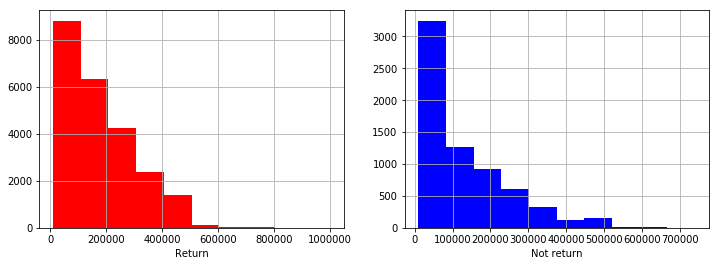

C:\Installed\Anaconda\envs\python_old\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Installed\Anaconda\envs\python_old\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Installed\Anaconda\envs\python_old\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


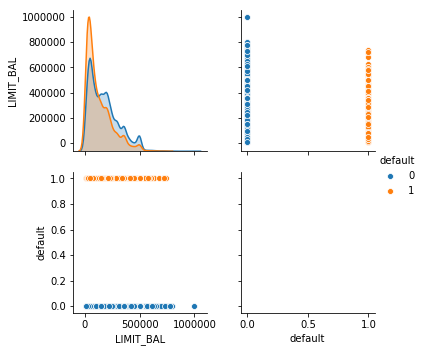

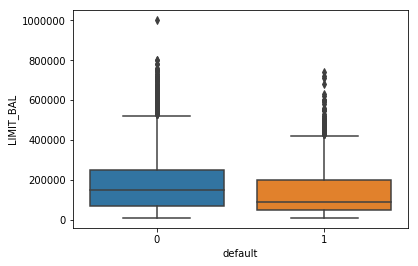

In [6]:
draw_graphs('LIMIT_BAL')

Признак LIMIT_BAL - вещественный, поэтому сначала проверим данные на нормальность с помощью QQ-графика и теста Шапиро-Уилка.

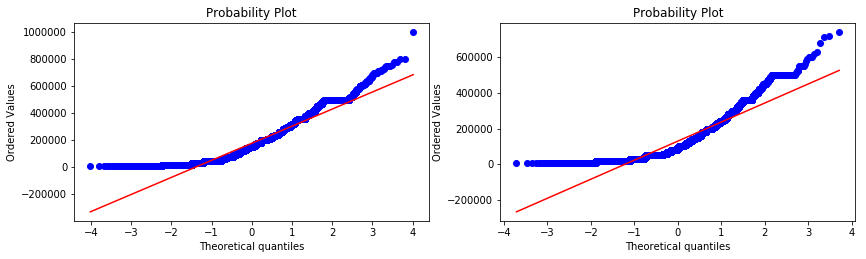

In [7]:
pylab.figure(figsize = (14, 8))
pylab.subplot(2, 2, 1)
stats.probplot(data_return['LIMIT_BAL'], dist = "norm", plot = pylab)
pylab.subplot(2, 2, 2)
stats.probplot(data_not_return['LIMIT_BAL'], dist = "norm", plot = pylab)
pylab.show()

 $H_0\colon$ размеры кредитного лимита распределены нормально.
 
 $H_1\colon$ $H_0$ неверна.

In [8]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_return['LIMIT_BAL'])
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_not_return['LIMIT_BAL'])

Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000


C:\Installed\Anaconda\envs\python_old\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Из QQ-графика видно, что данные распределены не нормально, то же самое подтвердилось с помощью теста Шапиро-Уилка, где уровень значимости получился < 0.05, из-за чего $H_0$ отвергается и принимается $H_1$ на уровне значимости 0.05. Поэтому для проверки гипотез будут применяться непараметрические критерии.

$H_0\colon$ медианные значения кредитного лимита равны у тех людей, кто вернул кредит и тех, кто его не вернул.

$H_1\colon$ $H_0$ неверна.

Построим интервальные оценки на основе bootstrap.

In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

return_median_scores = np.array(map(np.median, get_bootstrap_samples(data_return['LIMIT_BAL'].values, 10000)))
not_return_median_scores = np.array(map(np.median, get_bootstrap_samples(data_not_return['LIMIT_BAL'].values, 10000)))
diff_median_scores = return_median_scores - not_return_median_scores
print "95% confidence interval for the return median credit score:",  stat_intervals(return_median_scores, 0.05)
print "95% confidence interval for the not return median credit score:",  stat_intervals(not_return_median_scores, 0.05)
print "95% confidence interval for the diff median credit score:",  stat_intervals(diff_median_scores, 0.05)

95% confidence interval for the return median credit score: [150000. 150000.]
95% confidence interval for the not return median credit score: [80000. 90000.]
95% confidence interval for the diff median credit score: [60000. 70000.]


Поскольку интервалы не пересекаются, то медианные значения кредитного лимита отличаются у тех людей, кто вернул кредит и тех, кто его не вернул, поэтому отвергаем $H_0$ и принимаем $H_1$ на уровне значимости 0.05. Разница между медианами отличается практически в 2 раза, то есть практически в 2 раза отличается сумма, которую может дать банк заемщику, поэтому результат можно расценивать как практически значимый.

$H_0\colon$ распределения в выборках кредитного лимита у тех людей, кто вернул кредит и тех, кто его не вернул - равны ($F_{X_1}(x) = F_{X_2}(x)$).

$H_1\colon$ $H_0$ неверна ($F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$).

Применим перестановочный критерий для двухсторонней альтернативы для независимых выборок.

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test_ind(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)
    
permutation_test_ind(data_return['LIMIT_BAL'], data_not_return['LIMIT_BAL'], max_permutations = 10000)

0.0001

Поскольку p-value < 0.05, то на уровне значимости 0.05 отвергаем $H_0$ и принимаем $H_1$. Данный результат также практически значим - суммы кредитного лимита существенно отличаются для людей, кто вернул кредит, и для людей, кто не вернул, поэтому банк может с большей уверенностью выдавать кредит на большую сумму тем, кто вернул кредит и на меньшую тем, кто не вернул.

# 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

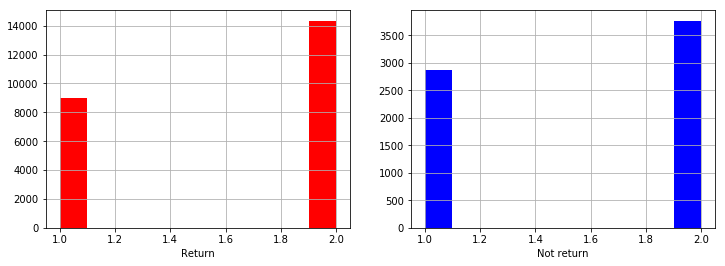

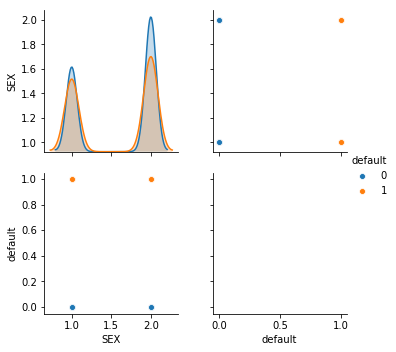

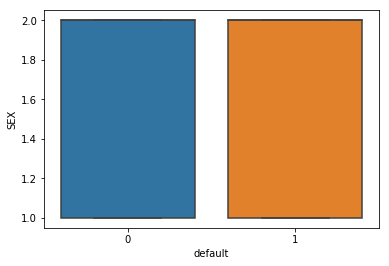

In [11]:
draw_graphs('SEX')

Поскольку данные бинарны, то будем применять критерий для распределения Бернулли для доли для двухсторонней альтернативы.

$H_0\colon$ доля женщин в группе людей вернувших и не вернувших кредит НЕ отличается.

$H_1\colon$ $H_0$ неверна.

Прежде всего приведем данные к виду 0 и 1, где 0 будет означать мужчину, а 1 - женщину.

In [12]:
sex_return = np.array(map(lambda x: 0 if x == 1 else 1, data_return['SEX'].values))
sex_not_return = np.array(map(lambda x: 0 if x == 1 else 1, data_not_return['SEX'].values))

Теперь попробуем интервально оценить долю женщин в выборках, для этого построим доверительный интервал Уилсона.

In [13]:
conf_interval_return = proportion_confint(sum(sex_return), len(sex_return), method = 'wilson')
conf_interval_not_return = proportion_confint(sum(sex_not_return), len(sex_not_return), method = 'wilson')
print '95%% confidence interval for a women probability, return: [%f, %f]' % conf_interval_return
print '95%% confidence interval for a women probability, not return: [%f, %f]' % conf_interval_not_return

95% confidence interval for a women probability, return: [0.607890, 0.620373]
95% confidence interval for a women probability, not return: [0.555102, 0.578938]


Поскольку интервалы не пересекаются, то доля женщин отличается в выборках людей, кто вернул кредит, и людей, кто кредит не вернул, поэтому отвергаем $H_0$ и принимаем $H_1$ на уровне значимости 0.05. Разница между долями отличается примерно на 0.05, поэтому не думаю, что полученный эффект можно расценивать как практически значимый.

Чтобы убедиться в полученном выводе, построим доверительный интервал и посчитаем достигаемый уровень значимости для разности двух долей.

In [14]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
    
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(sex_return, sex_not_return)
proportions_diff_z_test(proportions_diff_z_stat_ind(sex_return, sex_not_return))

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


4.472866521609831e-12

Полученный вывод подтвердился. Доверительный интервал не включает в себя 0, а достигаемый уровень значимости получился < 0.05, поэтому отвергаем $H_0$ и принимаем $H_1$ на уровне значимости 0.05.

# 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборт, не отдаст долг?

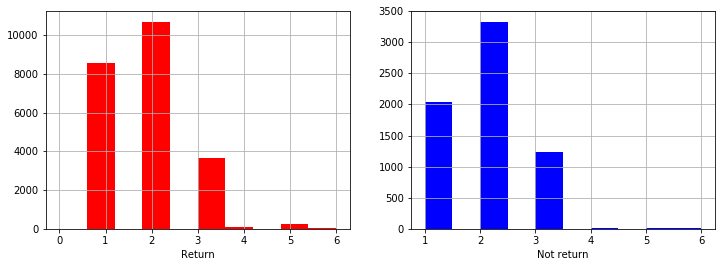

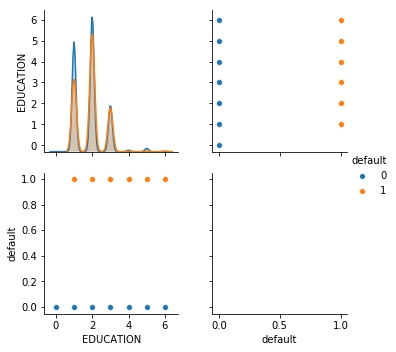

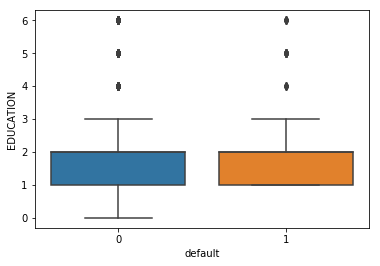

In [15]:
draw_graphs('EDUCATION')

Поскольку данные являются категориальными, то применим перестановочный критерий для двух независимых выборок

$H_0\colon$ образование не влияет на то, вернет ли человек долг ($F_{X_1}(x) = F_{X_2}(x)$).

$H_1\colon$ $H_0$ неверна ($F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$).

Сначала построим интервальные оценки на основе bootstrap.

In [16]:
return_education_bootstrap = get_bootstrap_samples(data_return['EDUCATION'].values, 10000)
not_return_education_bootstrap = get_bootstrap_samples(data_not_return['EDUCATION'].values, 10000)
print "95% confidence interval for the return education:",  stat_intervals(return_education_bootstrap, 0.05)
print "95% confidence interval for the not return education:",  stat_intervals(not_return_education_bootstrap, 0.05)

95% confidence interval for the return education: [1. 3.]
95% confidence interval for the not return education: [1. 3.]


Поскольку интервалы идентичны, то уровень образования одинаковый в выборках людей, кто вернул кредит, и людей, кто кредит не вернул, поэтому мы не можем отвергнуть $H_0$ на уровне значимости 0.05.

Проверим данный вывод, для этого посчитаем достигаемый уровень значимости.

In [17]:
permutation_test_ind(data_return['EDUCATION'], data_not_return['EDUCATION'], max_permutations = 10000)

0.0001

Поскольку p-value < 0.05, то на уровне значимости 0.05 отвергаем $H_0$ и принимаем $H_1$.

Для наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг построим таблицу сопряженности "образование" на "возврат долга" для разности между наблюдаемым и ожидаемым количеством человек. Также нужно убедиться, что условия применимости критерия Хи-квадрат выполняются: n >= 40 и не более 20% ячеек со значением меньше 5.

In [18]:
observed_return = np.bincount(data_return['EDUCATION'])
observed_not_return = np.bincount(data_not_return['EDUCATION'])
observed = [observed_return, observed_not_return]
observed

[array([   14,  8549, 10700,  3680,   116,   262,    43], dtype=int64),
 array([   0, 2036, 3330, 1237,    7,   18,    8], dtype=int64)]

Выборка не меньше 40 и всего 1 ячейка из 14 (что не более 20%) имеет значение меньше 5, поэтому можно применять критерий Хи-квадрат.

In [19]:
expected = stats.chi2_contingency(observed)[3]
diff_df = pd.DataFrame(
    data = observed - expected,
    columns = [
        u'доктор(0)',
        u'магистр(1)',
        u'бакалавр(2)',
        u'выпускник школы(3)',
        u'начальное образование(4)',
        u'прочее(5)',
        u'нет данных(6)'
    ],
    index = [
        u'вернул кредит',
        u'не вернул кредит'
    ]
)
diff_df

,доктор(0),магистр(1),бакалавр(2),выпускник школы(3),начальное образование(4),прочее(5),нет данных(6)
вернул кредит,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
не вернул кредит,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Чтобы привести таблицу к одному масштабу и при этом не потерять в интерпретируемости, можно посчитать доли.

In [20]:
observed_total = observed_return + observed_not_return
print observed_total
diff_prop_df = diff_df / observed_total
diff_prop_df

[   14 10585 14030  4917   123   280    51]


,доктор(0),магистр(1),бакалавр(2),выпускник школы(3),начальное образование(4),прочее(5),нет данных(6)
вернул кредит,0.2212,0.028852,-0.016149,-0.030376,0.164289,0.156914,0.064337
не вернул кредит,-0.2212,-0.028852,0.016149,0.030376,-0.164289,-0.156914,-0.064337


Как видно из таблицы, люди с уровнями образования магистр(1) с наибольшей вероятностью вернут кредит (уровни образования доктор(0), начальное образование(4), прочее(5) и нет данных(6) не в счет, поскольку выборка малочислена). Люди с образованием выпускник школы(3) c наибольшей вероятностью не вернут кредит. Данный вывод практически значим, поскольку на его основе банк будет принимать более взвешенное решение как о лимите, так и выдаче/не выдаче кредита для людей с разными уровнями образования.

# 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

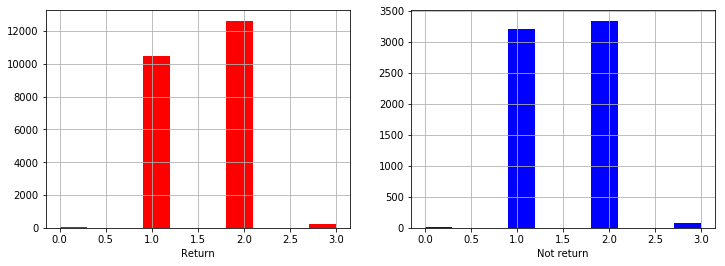

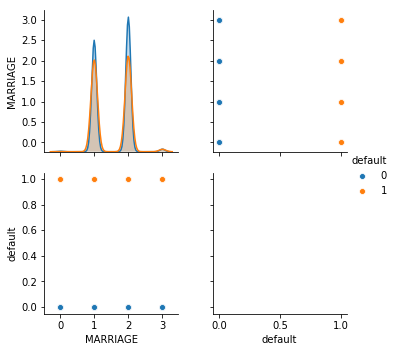

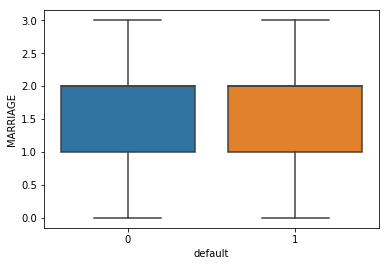

In [21]:
draw_graphs('MARRIAGE')

Поскольку индикатор дефолта - это бинарный признак, а семейное положение - категориальный, то можно вычислить коэффициент V Крамера. Для его вычисления понадобится критерий Хи-квадрат, поэтому построим таблицу сопряженности "семейное положение" на "возврат долга" для наблюдаемого количества человек. Также нужно убедиться, что условия применимости критерия Хи-квадрат выполняются: n >= 40 и не более 20% ячеек со значением меньше 5.

In [22]:
observed_return = np.bincount(data_return['MARRIAGE'])
observed_not_return = np.bincount(data_not_return['MARRIAGE'])
observed = np.array([observed_return, observed_not_return])
pd.DataFrame(
    data = observed,
    columns = [
        u'отказываюсь отвечать(0)',
        u'замужем/женат(1)',
        u'холост(2)',
        u'нет данных(3)'
    ],
    index = [
        u'вернул кредит',
        u'не вернул кредит'
    ]
)

,отказываюсь отвечать(0),замужем/женат(1),холост(2),нет данных(3)
вернул кредит,49,10453,12623,239
не вернул кредит,5,3206,3341,84


Выборка не меньше 40 и нет ячеек со значением меньше 5, поэтому можно применять критерий Хи-квадрат и вычислять коэффициент V Крамера.

$H_0\colon$ семейный статус и индикатор дефолта независимы.

$H_1\colon$ $H_0$ неверна.

In [23]:
chi2, p, dof, expected = stats.chi2_contingency(observed)
p

8.825862457577375e-08

Достигаемый уровень значимости < 0.05, поэтому на уровне значимости 0.05 отвергаем $H_0$ и принимаем $H_1$.

Теперь вычислим коэффициент V Крамера.

In [24]:
np.sqrt(chi2 / (np.sum(observed) * (min(observed.shape[0], observed.shape[1]) - 1)))

0.034478203662766466

Поскольку коэффициент V Крамера слишком мал, то можно говорить лишь об очень слабой взаимосвязи семейного положения и индикатора дефолта.

# 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы:

- a) о равенстве медианных значений возрастов людей
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения?

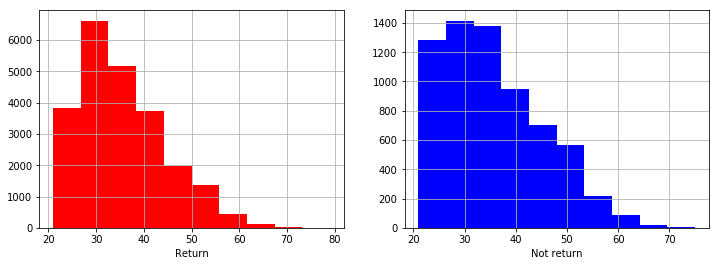

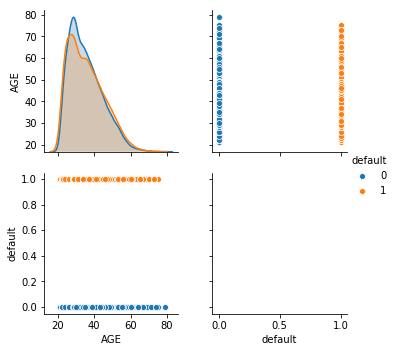

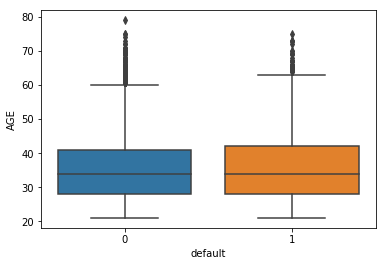

In [25]:
draw_graphs('AGE')

Признак AGE - вещественный, поэтому сначала проверим данные на нормальность с помощью QQ-графика и теста Шапиро-Уилка.

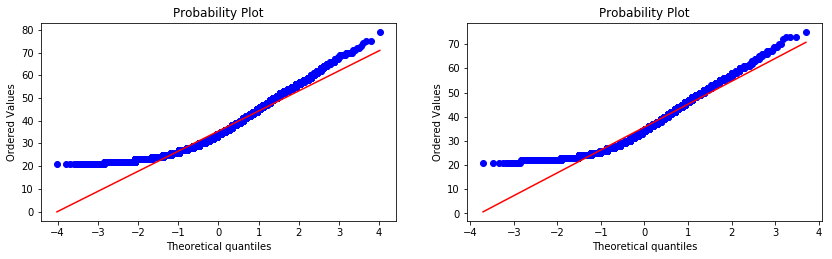

In [26]:
pylab.figure(figsize = (14, 8))
pylab.subplot(2, 2, 1)
stats.probplot(data_return['AGE'], dist = "norm", plot = pylab)
pylab.subplot(2, 2, 2)
stats.probplot(data_not_return['AGE'], dist = "norm", plot = pylab)
pylab.show()

$H_0\colon$ возраст людей распределен нормально.

$H_1\colon$ $H_0$ неверна.

In [27]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_return['AGE'])
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data_not_return['AGE'])

Shapiro-Wilk normality test, W-statistic: 0.949614, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.950164, p-value: 0.000000


Из QQ-графика видно, что данные распределены не нормально, то же самое подтвердилось с помощью теста Шапиро-Уилка, где уровень значимости получился < 0.05, из-за чего $H_0$ отвергается и принимается $H_1$ на уровне значимости 0.05. Поэтому для проверки гипотез будут применяться непараметрические критерии.

$H_0\colon$ медианные значения возрастов у тех людей, кто вернул кредит и тех, кто его не вернул.

$H_1\colon$ $H_0$ неверна.

Построим интервальные оценки на основе bootstrap.

In [28]:
return_age_bootstrap = np.array(map(np.median, get_bootstrap_samples(data_return['AGE'].values, 10000)))
not_return_age_bootstrap = np.array(map(np.median, get_bootstrap_samples(data_not_return['AGE'].values, 10000)))
diff_age = return_age_bootstrap - not_return_age_bootstrap
print "95% confidence interval for the return median age:",  stat_intervals(return_age_bootstrap, 0.05)
print "95% confidence interval for the not return median age:",  stat_intervals(not_return_age_bootstrap, 0.05)
print "95% confidence interval for the diff median credit score:",  stat_intervals(diff_age, 0.05)

95% confidence interval for the return median age: [34. 34.]
95% confidence interval for the not return median age: [34. 35.]
95% confidence interval for the diff median credit score: [-1.  0.]


Поскольку интервалы пересекаются, то медианные значения возрастов могут совпадать у тех людей, кто вернул кредит и тех, кто его не вернул, однако нельзя с уверенностью об этом сказать, поэтому необходимо посчитать достигаемый уровень значимости. Данный результат практически незначим, поскольку размер эффекта составляет всего 1 год.

Теперь попробуем вычислить достигаемый уровень значимости.

$H_0\colon$ распределения в выборках возрастов у тех людей, кто вернул кредит и тех, кто его не вернул - равны ($F_{X_1}(x) = F_{X_2}(x)$).

$H_1\colon$ $H_0$ неверна ($F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$).

Применим перестановочный критерий для двухсторонней альтернативы для независимых выборок.

In [29]:
permutation_test_ind(data_return['AGE'], data_not_return['AGE'], max_permutations = 10000)

0.017

Поскольку p-value < 0.05, то на уровне значимости 0.05 отвергаем $H_0$ и принимаем $H_1$. Данный результат практически незначим, поскольку размер эффекта составляет всего 1 год, вряд ли банк будет учитывать этот факт в принятии решения о том, выдать кредит или нет.